In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

from transformers import pipeline

import os

import data_extraction as da
import plotting
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eye4got/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
trans_df = pd.read_parquet(da.all_transcripts_df_dir)
subs_df = pd.read_parquet(da.sub_df_dir)

subs_df['movie'] = subs_df['movie'].str.title()
trans_df['movie_name'] = trans_df['movie_name'].str.title()

filtered_subs_df = subs_df[subs_df.movie.isin(trans_df['movie_name'].unique())]

In [3]:
def process_text(text: str, excl_stopwords: bool):
    
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha()]
    if excl_stopwords:
        filtered_tokens = [word for word in filtered_tokens if word not in stop_words]
        
    return filtered_tokens

def get_ngram_counts(text, n, top_n=10, excl_stopwords: bool = True):
    
    tokens = process_text(text, excl_stopwords)
    ngram_list = list(ngrams(tokens, n))
    ngram_counts = Counter(ngram_list)
    ngram_df = pd.DataFrame(ngram_counts.most_common(top_n), columns=['Ngram', 'Frequency'])
    ngram_df['Ngram'] = ngram_df['Ngram'].apply(lambda x: ' '.join(x))
    
    return ngram_df

def plot_ngrams(ngram_df: pd.DataFrame, title: str, output_path: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Frequency', y='Ngram', data=ngram_df, hue='type' if 'type' in ngram_df else None)
    plt.title(title, fontsize=20)
    plt.xlabel("Frequency", fontsize=20)
    plt.ylabel("")
    plt.xticks(fontsize=20)
    plt.yticks(rotation=45, fontsize=20)  # Rotate y-ticks and adjust fontsize
    plt.tight_layout()
    plt.savefig(output_path)

Text(0.5, 1.0, "Histogram of 'Thank you' Hallucinations by Movie")

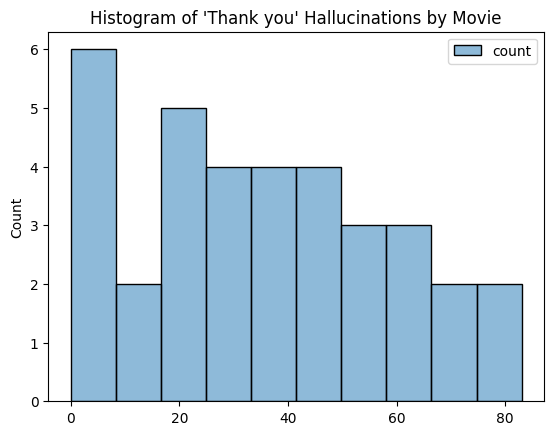

In [4]:
thank_you_count = trans_df[trans_df.text.eq(' Thank you.')] \
    .groupby('movie_name') \
    .text.count() \
    .reset_index() \
    .rename(columns={'text': 'count'})
missed_movies = set(trans_df.movie_name.unique()).difference(set(thank_you_count['movie_name']))
missed_rows = []

for movie in missed_movies:
    missed_rows.append({'movie_name': movie, 'count': 0})
    
thank_you_count = pd.concat([pd.DataFrame(missed_rows), thank_you_count])

sns.histplot(thank_you_count, bins=10)
plt.title('Histogram of \'Thank you\' Hallucinations by Movie')

Text(0.5, 1.0, "Histogram of 'Thank you' Hallucinations by Movie")

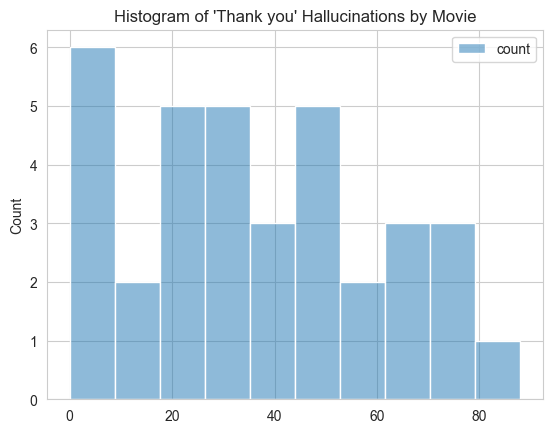

In [12]:
thank_you_count = trans_df[trans_df.text.str.contains('thank', case=False)] \
    .groupby('movie_name') \
    .text.count() \
    .reset_index() \
    .rename(columns={'text': 'count'})
missed_movies = set(trans_df.movie_name.unique()).difference(set(thank_you_count['movie_name']))
missed_rows = []

for movie in missed_movies:
    missed_rows.append({'movie_name': movie, 'count': 0})
    
thank_you_count = pd.concat([pd.DataFrame(missed_rows), thank_you_count])

sns.histplot(thank_you_count, bins=10)
plt.title('Histogram of \'Thank you\' Hallucinations by Movie')

In [5]:
red_trans_df = trans_df[trans_df.text.ne(' Thank you.')]

Text(0.5, 1.0, 'Histogram of Proportion of Text from Narrator by Movie')

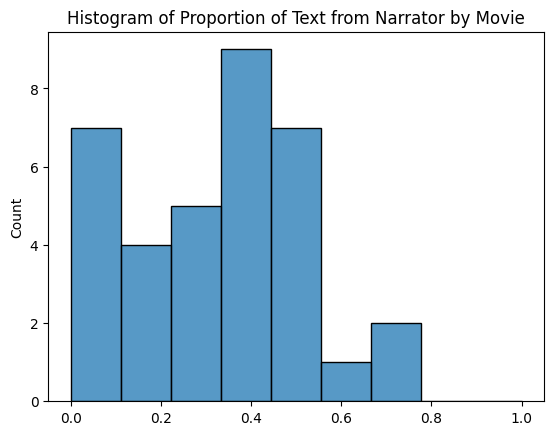

In [6]:
trans_wc_df = red_trans_df.groupby('movie_name').text.apply(' '.join).apply(process_text, excl_stopwords=True).apply(len)
subs_wc_df = filtered_subs_df.groupby('movie').raw_dialogue.apply(' '.join).apply(process_text, excl_stopwords=True).apply(len)

perc_narration_df = trans_wc_df / (subs_wc_df + trans_wc_df)

sns.histplot(perc_narration_df, binrange=(0, 1))
plt.title('Histogram of Proportion of Text from Narrator by Movie')

In [15]:
perc_narration_df.sort_values(ascending=False)

movie_name
Dune Part Two                        0.722018
Godzilla X Kong The New Empire       0.679048
The Super Mario Bros. Movie          0.661740
Elemental                            0.548329
Guardians Of The Galaxy Vol. 3       0.537081
Poor Things                          0.523798
Ghostbusters Frozen Empire           0.507639
Fast10                               0.504045
The Beekeeper                        0.468585
The Zone Of Interest                 0.460981
Top Gun Maverick                     0.432365
Past Lives                           0.429622
The Fabelmans                        0.422979
Kung Fu Panda 4                      0.401555
The Banshees Of Inisherin            0.393790
The Fall Guy                         0.381278
Wonka                                0.379429
Women Talking                        0.371159
The Silence Of The Lambs             0.347695
Elvis                                0.317584
Maestro                              0.269203
Bob Marley One Love    

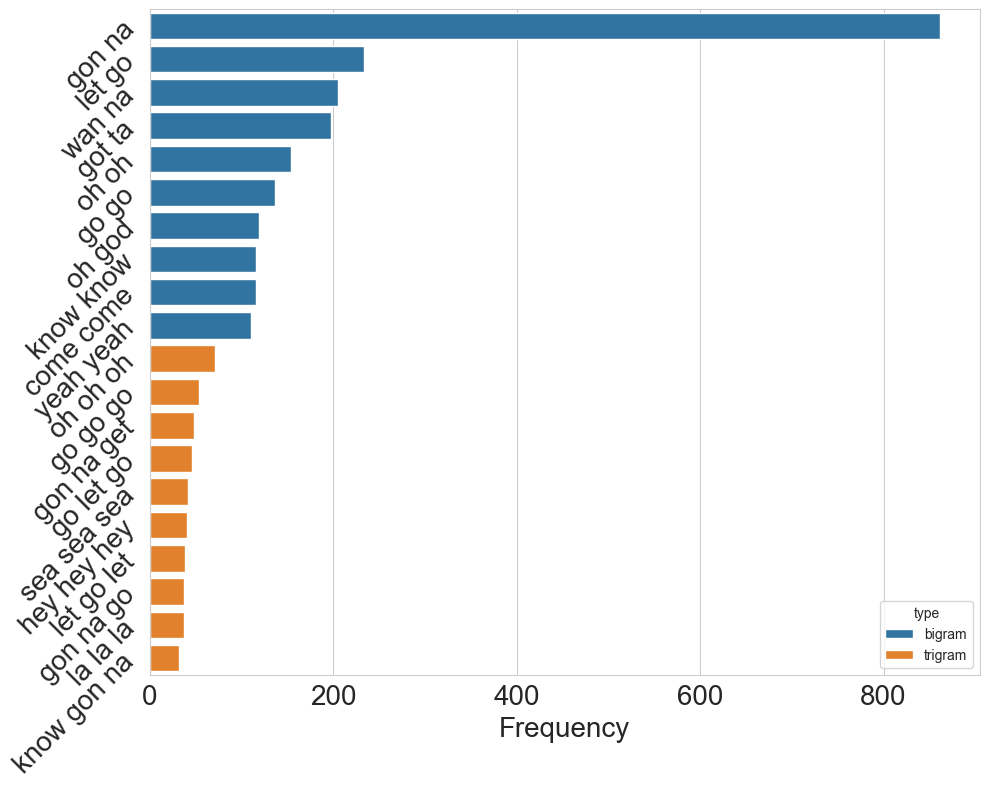

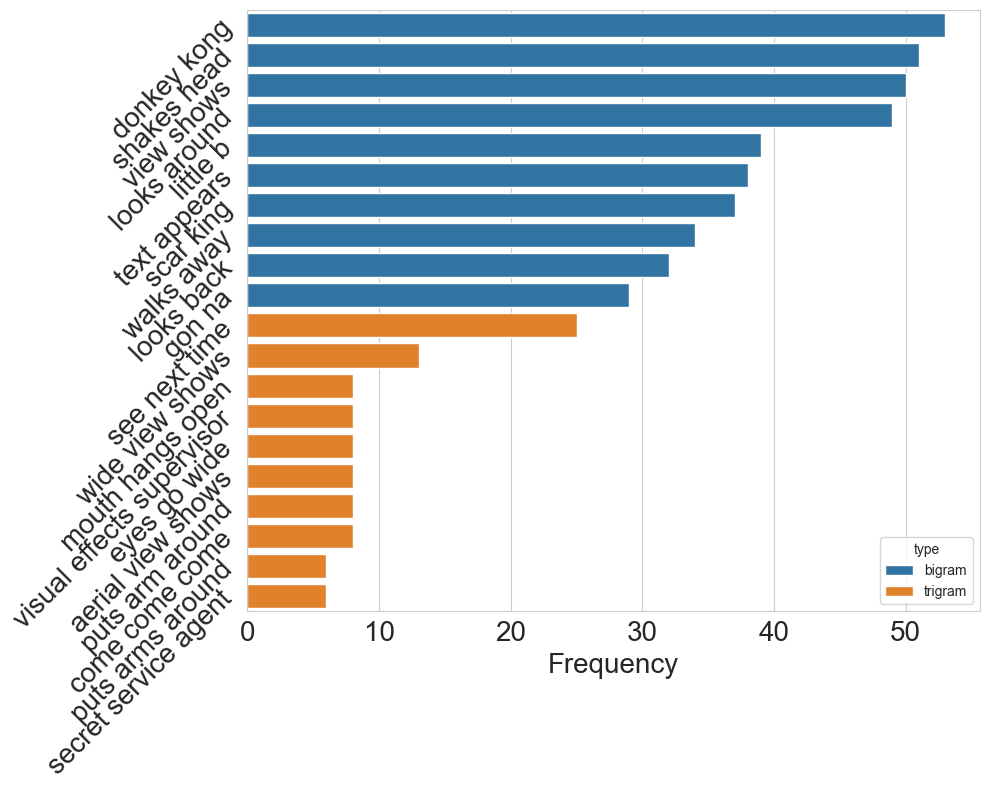

In [7]:
subs_text = ' '.join(filtered_subs_df.raw_dialogue)
trans_text = ' '.join(red_trans_df.text)
dataset = {'Subtitles': subs_text, 'Transcripts': trans_text}

# dialogue_df = trans_df[trans_df.is_dialogue.eq(False)]
# narration_df = trans_df[trans_df.is_dialogue.eq(True)]

# dataset = {'Dialogue': ' '.join(dialogue_df.text), 'Narration': narration_df.text}

excl_stopwords = True

for title, text in dataset.items():
    bigram_df = get_ngram_counts(text, 2, excl_stopwords=excl_stopwords)
    trigram_df = get_ngram_counts(text, 3, excl_stopwords=excl_stopwords)

    bigram_df['type'] = 'bigram'
    trigram_df['type'] = 'trigram'

    full_df = pd.concat([bigram_df, trigram_df])
    plot_ngrams(full_df, "", os.path.join(plotting.output_dir, f'{title} ngram ranking.png'))

In [8]:
roberta_base_model = pipeline('text-classification', model='cardiffnlp/twitter-roberta-large-sensitive-multilabel')

# results = content_analyzer(text, truncation=True, max_length=512)
#                 for result in results:
#                     if result['label'].lower() == 'offensive' and result['score'] > 0.5:  # Threshold for confidence
#                         abusive_count += 1

Device set to use cuda:0


In [11]:
red_trans_df['sens_class'] = red_trans_df['text'].apply(roberta_base_model, truncation=True)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


KeyboardInterrupt: 